number of good matches:  22


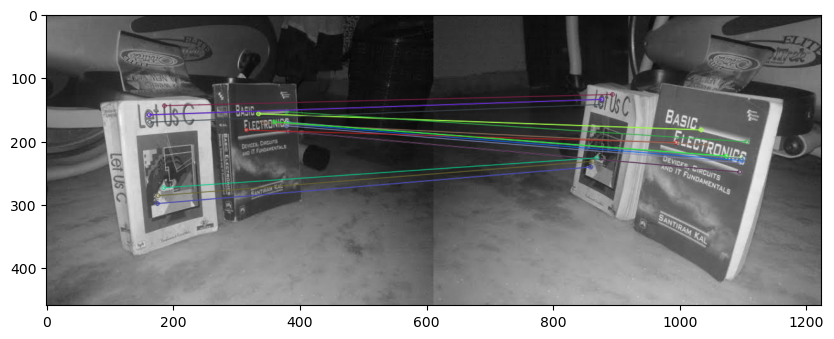

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

left = cv.imread('left.jpg', cv.IMREAD_GRAYSCALE)
right = cv.imread('right.jpg', cv.IMREAD_GRAYSCALE)

sift = cv.SIFT_create(nfeatures=200)

left_keypoints, left_desc = sift.detectAndCompute(left, None)
right_keypoints, right_desc = sift.detectAndCompute(right, None)

FLANN_INDEX_KDTREE = 1

index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

search_params = dict(checks=50)

flann = cv.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(left_desc, right_desc, k=2)

good = []

# ratio test as Lowe's paper
for i,match in enumerate(matches):
    m,n = match
    if m.distance < 0.6*n.distance:
        good.append(m)

good = tuple(good)

good = sorted(good, key = lambda x:x.distance)

print('number of good matches: ', len(good))

res = cv.drawMatches(left, left_keypoints, right, right_keypoints, \
                    good, None, \
                    flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(10,10))
plt.imshow(res)

In [2]:
pts_left = []
pts_right = []

for m in good:
    pts_left.append(left_keypoints[m.queryIdx].pt)
    pts_right.append(right_keypoints[m.trainIdx].pt)
    
pts_left = np.int32(pts_left)
pts_right = np.int32(pts_right)

F, mask = cv.findFundamentalMat(pts_left, pts_right, cv.FM_LMEDS) 

pts_left = pts_left[mask.ravel()==1]
pts_right = pts_right[mask.ravel()==1]

In [3]:
def drawlines(img1, img2, lines1, pts1, pts2):
    rows,cols = img1.shape
    img1 = cv.cvtColor(img1, cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2, cv.COLOR_GRAY2BGR)

    for line,pt1,pt2 in zip(lines1,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        
        a,b,c = line
        x0,y0 = map(int, [0, -c/b ])
        x1,y1 = map(int, [cols, -(a*cols+c)/b ])
        
        img1 = cv.line(img1, (x0,y0), (x1,y1), color, 1)  # draw line on first image
        img1 = cv.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv.circle(img2, tuple(pt2), 5, color, -1)

    return img1,img2


(([], []), ([], []))

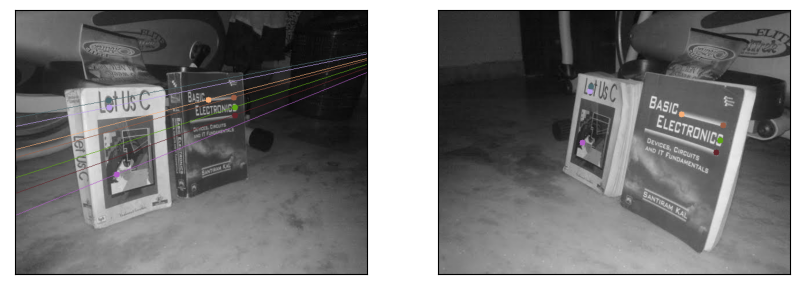

In [4]:
lines_left = cv.computeCorrespondEpilines(pts_right.reshape(-1,1,2), 2, F)
lines_left = lines_left.reshape(-1,3)

res_left,res_right = drawlines(left, right, lines_left, pts_left, pts_right)

plt.figure(figsize=(10,10))

plt.subplot(121),plt.imshow(res_left)
plt.xticks([]), plt.yticks([])

plt.subplot(122),plt.imshow(res_right)
plt.xticks([]), plt.yticks([])

(([], []), ([], []))

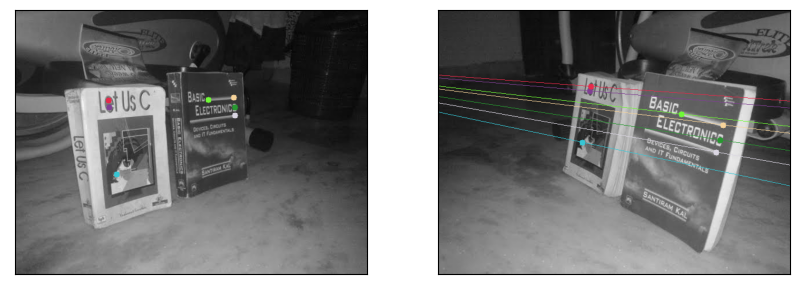

In [5]:
lines_right = cv.computeCorrespondEpilines(pts_left.reshape(-1,1,2), 1, F)
lines_right = lines_right.reshape(-1,3)

res_right,res_left = drawlines(right, left, lines_right, pts_right, pts_left)

plt.figure(figsize=(10,10))

plt.subplot(121),plt.imshow(res_left)
plt.xticks([]), plt.yticks([])

plt.subplot(122),plt.imshow(res_right)
plt.xticks([]), plt.yticks([])